# Load and Evaluate a Model (OOP)

In [1]:
import rnn_evaluation
from processing import preprocessing
import pandas as pd
import numpy as np

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [3]:
load_processed_df_from_disk = True

if load_processed_df_from_disk:
    # load processed spectoragramms
    # raw_data_df = pd.read_json('/datasets/UrbanSound8K/processed/mean_mfcc_data.json')
    raw_data_df = pd.read_json(
        "/home/bilgecan_cihan/audio-predictive-maintenance/data_science/processed_data/mean_mfcc_data_bilge.json")

else:
    # preprocess the raw dataset
    raw_data_df = preprocessing.load_dataset()
    raw_data_df['feature'] = raw_data_df['feature'].apply(
        preprocessing.calculate_mean_mfcc, preprocessing.DEFAULT_SAMPLE_RATE)

    # save to json for later loadings
    raw_data_df.to_json(
        "/home/bilgecan_cihan/audio-predictive-maintenance/data_science/processed_data/mean_mfcc_data_bilge.json")

data_df = preprocessing.filter_mfccs(raw_data_df)

/home/bilgecan_cihan/.local/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [4]:
data_df  # New dataframe has an additional "native_sample_rate" column

,feature,label,fold,sample_rate
0,"[[-457.6953430176, -451.024810791, -450.686126...",children_playing,5,44100
1,"[[-468.0367126465, -467.4226379395, -481.04653...",children_playing,5,44100
2,"[[-422.4221496582, -411.9085083008, -409.46243...",children_playing,5,44100
3,"[[-438.1016235352, -434.4778747559, -443.32839...",children_playing,5,44100
4,"[[-446.1983642578, -449.6851196289, -454.75500...",children_playing,5,44100
...,...,...,...,...
7329,"[[-401.3293457031, -396.9149169922, -401.22232...",car_horn,7,44100
7330,"[[-332.5479125977, -335.1363830566, -342.24682...",car_horn,7,44100
7331,"[[-395.4813537598, -397.266784668, -403.424102...",car_horn,7,44100
7332,"[[-342.3815307617, -339.073425293, -343.508819...",car_horn,7,44100


In [5]:
# Split data into testing and training sets
X_train, X_test, y_train, y_test = preprocessing.create_training_data_RNN(data_df)

# Use all data to make predictions with the best saved model
X, y = preprocessing.create_prediction_data(data_df)

In [6]:
sample_rates = np.array(data_df.sample_rate.tolist())
sample_rates

array([44100, 44100, 44100, ..., 44100, 44100, 44100])

In [7]:
num_outputs = data_df['label'].unique().shape[0]  # labels = 10
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print("num_outputs: ", num_outputs)
print()
print("X shape:", X.shape)
print("y shape:", y.shape)

X_train shape: (5867, 173, 40)
X_test shape: (1467, 173, 40)
y_train shape: (5867, 10)
y_test shape: (1467, 10)
num_outputs:  10

X shape: (7334, 173, 40)
y shape: (7334, 10)


In [8]:
model = rnn_evaluation.RNN_eval()

0 air_conditioner
1 car_horn
2 children_playing
3 dog_bark
4 drilling
5 engine_idling
6 gun_shot
7 jackhammer
8 siren
9 street_music


In [9]:
model.load_model(model_file_path="models/saved_models_DP_0.2/best_model")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               86528     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 16)                2064      
_________________________________________________________________
dropout_26 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 10)                170       
Total params: 88,762
Trainable params: 88,762
Non-trainable params: 0
_________________________________________________________________


In [10]:
# Evaluate model
model.evaluate(X_train, X_test, y_train, y_test)

1467/1467 [==============================] - 10s 7ms/step - loss: 0.3392 - accuracy: 0.9380
Testing Accuracy:  0.9379686713218689
Training Accuracy:  0.9882392883300781


(0.9882392883300781, 0.9379686713218689)

# Create Confusion Matrix

In [11]:
# Make predictions with all available data
model.make_prediction(X)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [12]:
# Create confusion matrix (argument: true labels)
cm = model.create_confusion_matrix(y)
cm

Predicted,0,1,2,3,4,5,6,7,8,9,All
Actual,,,,,,,,,,,
0,986,0,1,2,0,1,0,1,0,6,997
1,0,199,1,0,0,1,0,0,0,2,203
2,0,1,933,11,4,10,0,1,1,15,976
3,0,0,7,658,1,0,0,0,6,3,675
4,0,0,2,1,796,1,0,3,1,1,805
5,0,0,2,0,0,958,0,0,1,0,961
6,0,0,0,1,0,0,15,0,0,0,16
7,1,0,0,0,6,2,0,793,0,2,804
8,0,1,2,2,1,2,0,0,886,3,897


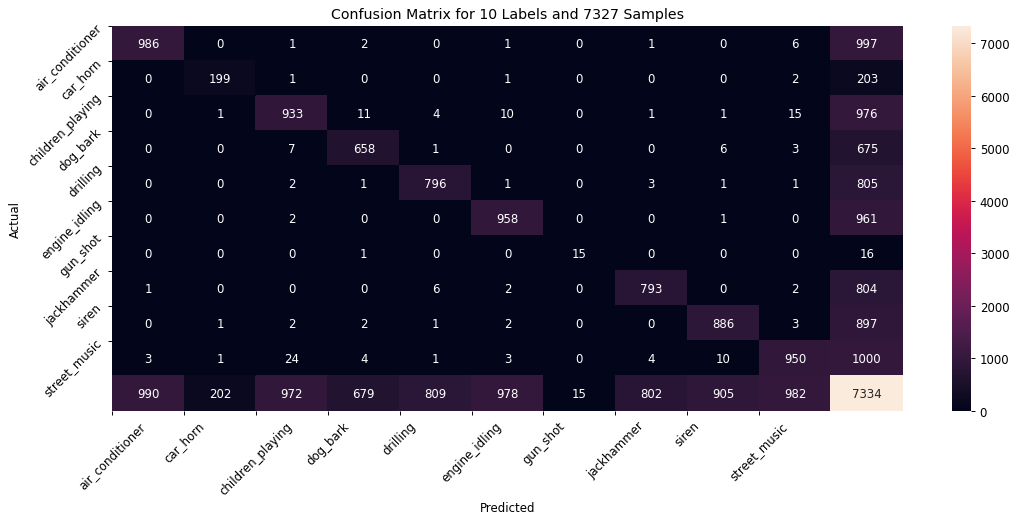

<Figure size 432x288 with 0 Axes>

In [13]:
model.tabulate_confusion_matrix()

# Calculate Precision and Recall

In [14]:
precision_df = model.calculate_precision()
precision_df

,labels_sorted,precision_score
0,air_conditioner,0.9960
1,car_horn,0.9851
2,children_playing,0.9599
3,dog_bark,0.9691
4,drilling,0.9839
5,engine_idling,0.9796
6,gun_shot,1.0000
7,jackhammer,0.9888
8,siren,0.9790
9,street_music,0.9674


In [15]:
recall_df = model.calculate_recall()
recall_df

,labels_sorted,recall_score
0,air_conditioner,0.9890
1,car_horn,0.9803
2,children_playing,0.9559
3,dog_bark,0.9748
4,drilling,0.9888
5,engine_idling,0.9969
6,gun_shot,0.9375
7,jackhammer,0.9863
8,siren,0.9877
9,street_music,0.9500


# Plot Sample Rate vs Number of Samples of Mispredicted Samples

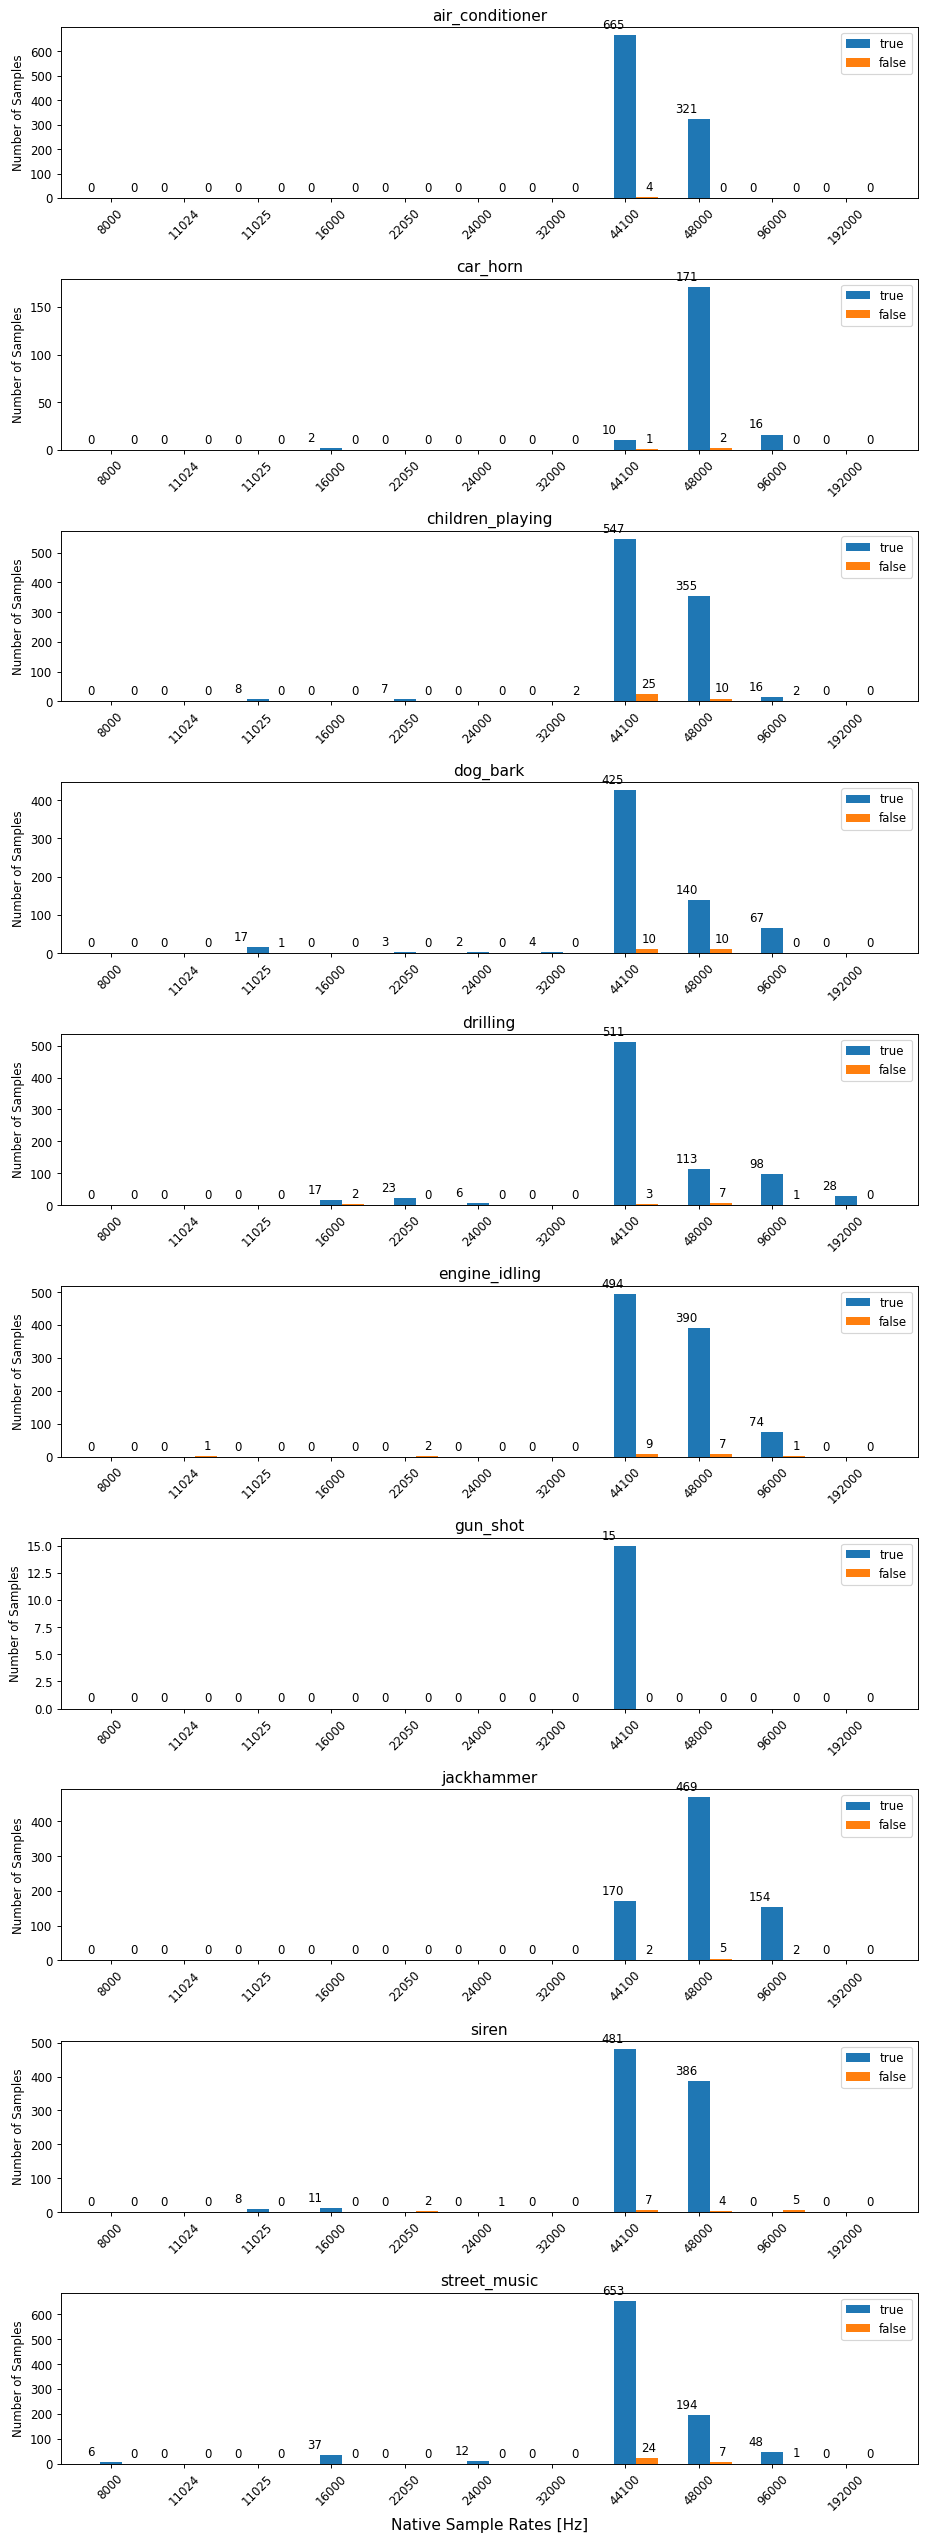

In [16]:
model.plot_sample_rates_mispredicted_classes(data_df)